### Plot all data from manuscript

In [3]:
curr_dir = f'/user_data/vayzenbe/GitHub_Repos/hemispace' #CHANGE AS NEEEDED CAUSE ITS FOR VLAAAD

import sys
sys.path.insert(0,curr_dir)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import scipy.stats as stats
import scipy
import statsmodels.api as s
from sklearn import metrics

import pdb
import hemispace_params as params

from plotnine import *

#hide warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
data_dir = params.data_dir
results_dir = params.results_dir
fig_dir = params.fig_dir

sub_info = params.sub_info
task_info = params.task_info

suf = params.suf
rois = params.rois
hemis = params.hemis



#load subject info
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')



In [18]:
def create_confound_plot(resample_data,data_mean, indiv_data,  analysis, analysis_name):
    seed = 1
    p = ggplot(resample_data, aes(x = 'hemi', y = analysis, fill = 'hemi'))  + \
                geom_violin( alpha = .3, position =  position_dodge(.9) ) + \
                geom_jitter(indiv_data,aes(x = 'hemi', y = analysis, fill = 'hemi'), shape = 'o', size = 3, position = position_jitterdodge(dodge_width=.9, jitter_width = 0.2, random_state = seed)) + \
                geom_linerange(data_mean, aes(x = 'hemi', ymin = f'{analysis} - se', ymax = f'{analysis} + se', fill = 'hemi'), size = 1,position = position_dodge(.9)) + \
                geom_point(data_mean, aes(x = 'hemi', y = analysis, fill = 'hemi'), shape = 's', size = 3,position = position_dodge(.9)) + \
                geom_label(indiv_data, aes(x = 'hemi', y = analysis, label = 'sub_code'),  position = position_jitterdodge(dodge_width=.9, jitter_width = 0.2, random_state = seed),  size = 8) + \
                scale_fill_manual(values = ['#808080','#ee7183', '#7398af']) + \
                xlab('Group') + ylab(analysis_name) + \
                theme_classic() + \
                theme(text = element_text(color ='black'), 
                    axis_text_y= element_text(size = 12),
                    axis_title=element_text(size = 14),
                    axis_line=element_line(), 
                    legend_position = 'none',
                    panel_border=element_blank(),
                    figure_size = (3, 5),
                    axis_line_x=element_blank(),
                    axis_text_x=element_blank(),
                    axis_ticks_major_x=element_blank(),
                    axis_title_x = element_blank())+ \
                    labs(fill='Hemisphere') #+ ggtitle(f'{cond}')

    #replace space in analysis name
    analysis_name = analysis_name.replace(' ', '_')
    p.save(f'{fig_dir}/confound/{analysis_name}.png', width=3, height=5, dpi = 300)
    print(p)

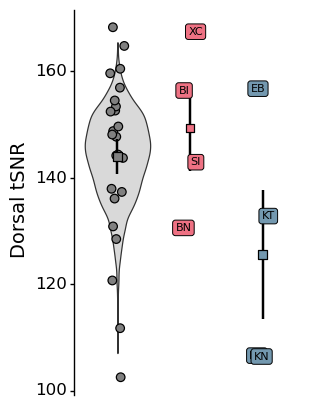

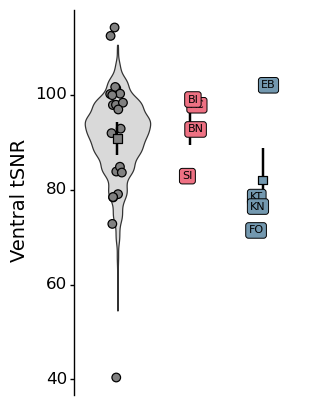

"\nseed = 2\np = ggplot(resample_data_long, aes(x = 'roi', y = data_type, fill = 'hemi'))  +             geom_violin( alpha = .3, position =  position_dodge(.9) ) +             geom_jitter(data_summary,aes(x = 'roi', y = data_type, fill = 'hemi'), shape = 'o', size = 3, position = position_jitterdodge(dodge_width=.9, jitter_width = 0.2, random_state = seed)) +             geom_linerange(data_mean, aes(x = 'roi', ymin = f'{data_type} - se', ymax = f'{data_type} + se', fill = 'hemi'), size = 1,position = position_dodge(.9)) +             geom_point(data_mean, aes(x = 'roi', y = data_type, fill = 'hemi'), shape = 's', size = 3,position = position_dodge(.9)) +             geom_label(data_summary, aes(x = 'roi', y = data_type, label = 'sub_code'),  position = position_jitterdodge(dodge_width=.9, jitter_width = 0.2, random_state = seed),  size = 8) +             scale_fill_manual(values = ['#808080','#ee7183', '#7398af']) +             xlab('Group') + ylab(data_name) +             theme_clas

In [19]:
'''
Create roi confound plots
'''

data_type = 'tsnr'
data_name = 'tSNR'


#load confound data
data_summary = pd.read_csv(f'{results_dir}/confound/confound_summary_roi.csv')

#load resamples
dorsal = pd.read_csv(f'{results_dir}/confound/confound_resamples_dorsal_visual_cortex_roi.csv')
ventral = pd.read_csv(f'{results_dir}/confound/confound_resamples_ventral_visual_cortex_roi.csv')

resample_data = dorsal
#rename tsnr column to dorsal
resample_data = resample_data.rename(columns = {'tsnr': 'Dorsal'})
resample_data['Ventral'] = ventral['tsnr']
resample_data_long = pd.melt(resample_data, var_name='roi', value_name='tsnr')

resample_data_long['hemi'] = 'Control'



#capitalize hemi
data_summary['hemi'] = data_summary['hemi'].str.capitalize()
#replace control hemi with 'Control'
data_summary.loc[(data_summary['hemi'] == 'Left') & (data_summary['group'] == 'control'), 'hemi'] = 'Control'
data_summary.loc[(data_summary['hemi'] == 'Right') & (data_summary['group'] == 'control'), 'hemi'] = 'Control'

#replace control tsnr with mean for each sub
for roi in data_summary['roi'].unique():
    for sub in data_summary['sub'].unique():
        mean_tsnr = data_summary[(data_summary['sub'] == sub) & (data_summary['roi'] == roi)]['tsnr'].mean()
        data_summary.loc[(data_summary['sub'] == sub) & (data_summary['roi'] == roi), 'tsnr'] = mean_tsnr

#remane roi 
data_summary['roi'] = data_summary['roi'].str.replace('dorsal_visual_cortex', 'Dorsal')
data_summary['roi'] = data_summary['roi'].str.replace('ventral_visual_cortex', 'Ventral')

#drop task column
data_summary = data_summary.drop(columns = ['task', 'rot','trans'])

#drop nan rows
data_summary = data_summary.dropna()

#reset index
data_summary = data_summary.reset_index(drop = True)

#drop duplicates
data_summary = data_summary.drop_duplicates()

# for each sub in data_summary, get the sub's code from sub_info
for sub in data_summary['sub'].unique():
    sub_code = sub_info[sub_info['sub'] == sub]['code'].values[0]
    data_summary.loc[data_summary['sub'] == sub, 'sub_code'] = sub_code

#create mean and SE data for patients
data_mean = data_summary.groupby(['hemi','roi']).mean().reset_index()
data_mean_se = data_summary.groupby(['hemi','roi']).sem().reset_index()
data_mean['se'] = data_mean_se[data_type]

#resample_data['hemi'] = 'Control'

for roi in resample_data_long['roi'].unique():
    #extract roi data for resample, data_summary, and data_mean
    resample_data_roi = resample_data_long[resample_data_long['roi'] == roi]
    data_summary_roi = data_summary[data_summary['roi'] == roi]
    data_mean_roi = data_mean[data_mean['roi'] == roi]

    #create plot
    create_confound_plot(resample_data_roi,data_mean_roi, data_summary_roi,  data_type, f'{roi} {data_name}')

    


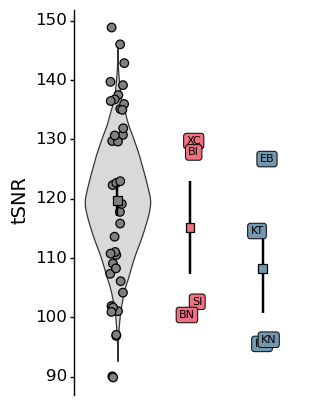

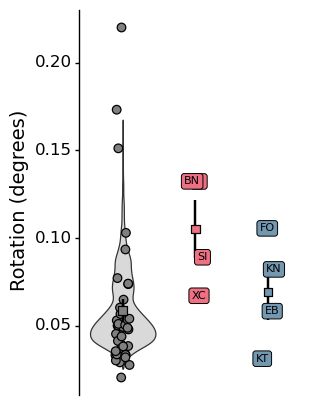

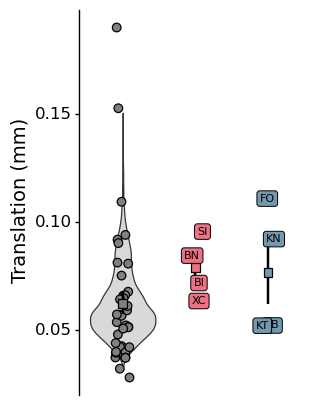

In [20]:
'''
Create whole brain confound plots
'''
data_types = ['tsnr','rot','trans']
data_names = ['tSNR', 'Rotation (degrees)', 'Translation (mm)']

#load confound data
data_summary = pd.read_csv(f'{results_dir}/confound/confound_summary{suf}.csv')
#convert rot from radians to degrees
data_summary['rot'] = data_summary['rot'].apply(np.degrees)
#load resamples
resample_data = pd.read_csv(f'{results_dir}/confound/confound_resamples{suf}.csv')
resample_data['rot'] = resample_data['rot'].apply(np.degrees)





#capitalize hemi
data_summary['hemi'] = data_summary['hemi'].str.capitalize()

# for each sub in data_summary, get the sub's code from sub_info
for sub in data_summary['sub'].unique():
    sub_code = sub_info[sub_info['sub'] == sub]['code'].values[0]
    data_summary.loc[data_summary['sub'] == sub, 'sub_code'] = sub_code

#replace control hemi with 'Control'
data_summary.loc[(data_summary['hemi'] == 'Left') & (data_summary['group'] == 'control'), 'hemi'] = 'Control'
data_summary.loc[(data_summary['hemi'] == 'Right') & (data_summary['group'] == 'control'), 'hemi'] = 'Control'

#replace control tsnr with mean for each sub
for sub in data_summary['sub'].unique():
    mean_tsnr = data_summary[(data_summary['sub'] == sub) & (data_summary['group'] == 'control')]['tsnr'].mean()
    data_summary.loc[(data_summary['sub'] == sub) & (data_summary['group'] == 'control'), 'tsnr'] = mean_tsnr

#drop duplicate rows
data_summary = data_summary.drop_duplicates()

#calc data mean
for data_type, data_name in zip(data_types, data_names):

    #create mean and SE data for patients
    data_mean = data_summary.groupby(['hemi']).mean().reset_index()
    data_mean_se = data_summary.groupby(['hemi']).sem().reset_index()
    data_mean['se'] = data_mean_se[data_type]

    resample_data['hemi'] = 'Control'


    create_confound_plot(resample_data,data_mean, data_summary,  data_type, data_name)



In [6]:
'''
Calculate t-test between hemis for controls
'''
conds = ['word', 'face','tool','space']
rois = ['ventral_visual_cortex','ventral_visual_cortex','dorsal_visual_cortex','dorsal_visual_cortex']
analysis_type = 'selectivity'

#load data summary
data_summary = pd.read_csv(f'{results_dir}/{analysis_type}/{analysis_type}_summary{suf}.csv')

#extract controls
data_summary = data_summary[data_summary['group']=='control']

#loop through conds
for cond, roi in zip(conds, rois):
    #exract data for cond and roi
    curr_data = data_summary[(data_summary['cond']==cond) & (data_summary['roi']==roi)]

    #convert data to wide by subject
    curr_data = curr_data.pivot(index='sub', columns='hemi', values='sum_selec_norm')
    
    #run paired t-test between hemis
    t, p = stats.ttest_rel(curr_data['left'], curr_data['right'])

    #calculate effect size
    d = (curr_data['left'].mean() - curr_data['right'].mean()) / (np.sqrt((curr_data['left'].std() ** 2 + curr_data['right'].std() ** 2) / 2))


    print(cond, t, curr_data.shape[0]-1, p, d)


word 6.153052993938021 20 5.184353703384293e-06 1.3271658224942593
face -4.550482953636804 20 0.0001945079514860682 -0.7697516781186213
tool 3.1965403952753437 23 0.004011695150413277 0.4167262578324006
space -5.827523465289514 23 6.142709211936777e-06 -0.45091012999091545


In [22]:
'''
Calculate what proportion of controls are outside the range for the non-preferred hemisphere
'''

summary_type = 'sum_selec_norm'
analysis_type = 'selectivity'
conds = ['word', 'face','tool','space']
rois = ['ventral_visual_cortex','ventral_visual_cortex','dorsal_visual_cortex','dorsal_visual_cortex']
pref_hemis = ['left','right','left','right']
nonpref_hemis = ['right','left','right','left']

#load resample data
act_resamples = pd.read_csv(f'{results_dir}/{analysis_type}/resamples/{summary_type}_resamples{suf}.csv')
#replace columns with dorsal visual cortex with dvc
for col in act_resamples.columns:
    if 'dorsal_visual_cortex' in col:
        new_col = col.replace('dorsal_visual_cortex','dvc')
        act_resamples.rename(columns={col:new_col}, inplace=True)
    if 'ventral_visual_cortex' in col:
        new_col = col.replace('ventral_visual_cortex','vvc')
        act_resamples.rename(columns={col:new_col}, inplace=True)
        
#convert act resamples to long format
act_resamples_long = pd.melt(act_resamples, var_name='type', value_name=analysis_type)
act_resamples_long[['cond','hemi','roi']] = act_resamples_long['type'].str.split('_',expand=True)

#rename roi column
act_resamples_long['roi'].replace('dvc','dorsal_visual_cortex',inplace=True)
act_resamples_long['roi'].replace('vvc','ventral_visual_cortex',inplace=True)

for cond, roi, pref_hemi, nonpref_hemi in zip(conds, rois, pref_hemis, nonpref_hemis):

    #load summary data
    data_summary = pd.read_csv(f'{results_dir}/{analysis_type}/{analysis_type}_summary{suf}.csv')

    #extract data for cond, roi, pref hemi, and controls
    data_summary = data_summary[(data_summary['cond']==cond) & (data_summary['roi']==roi) & (data_summary['group']=='control') & (data_summary['hemi']==pref_hemi)]

    #extract resample data for cond and roi
    curr_resamples = act_resamples_long[(act_resamples_long['cond']==cond) & (act_resamples_long['roi']==roi) & (act_resamples_long['hemi']==nonpref_hemi)]

    #calculate CIs for resamples
    resample_ci = curr_resamples.groupby(['cond','roi','hemi']).quantile([.025, .975]).reset_index()

    #convert each subjects score to a percentile relative to the resamples
    for sub in data_summary['sub'].unique():
        #extract subject's score
        sub_score = data_summary[data_summary['sub']==sub][summary_type].values[0]
        #calculate percentile
        percentile = stats.percentileofscore(curr_resamples['selectivity'], sub_score)
        #add percentile to data summary
        data_summary.loc[data_summary['sub']==sub, 'percentile'] = percentile

    #count how many subjects have a percentile greater thant 97.5
    count = data_summary[data_summary['percentile'] > 97.5].shape[0]
    

    #compute binomial test
    binom_test = stats.binom_test(count, data_summary.shape[0], p =.5)
    
    print(cond, roi, count/data_summary.shape[0], binom_test)
    
    





    

word ventral_visual_cortex 0.6666666666666666 0.18924713134765625
face ventral_visual_cortex 0.3333333333333333 0.18924713134765625
tool dorsal_visual_cortex 0.2916666666666667 0.06391465663909912
space dorsal_visual_cortex 0.25 0.022655844688415527


In [20]:
binom_test

0.09462356567382812

In [5]:
def create_violin(resample_data,data_mean, indiv_data,  analysis, analysis_name, roi, cond):
    seed = 2
    p = ggplot(resample_data, aes(x = 'group', y = analysis, fill = 'hemi'))  + \
                geom_violin( alpha = .3, position =  position_dodge(.9) ) + \
                geom_jitter(indiv_data,aes(x = 'group', y = analysis, fill = 'hemi'), shape = 'o', size = 3, position = position_jitterdodge(dodge_width=.9, jitter_width = 0.2, random_state = seed)) + \
                geom_linerange(data_mean, aes(x = 'group', ymin = f'{analysis} - se', ymax = f'{analysis} + se', fill = 'hemi'), size = 1,position = position_dodge(.9)) + \
                geom_point(data_mean, aes(x = 'group', y = analysis, fill = 'hemi'), shape = 's', size = 3,position = position_dodge(.9)) + \
                geom_label(indiv_data, aes(x = 'group', y = analysis, label = 'sub_code'),  position = position_jitterdodge(dodge_width=.9, jitter_width = 0.2, random_state = seed),  size = 8) + \
                scale_fill_manual(values = ['#ee7183', '#7398af']) + \
                xlab('Group') + ylab(analysis_name) + \
                theme_classic() + \
                theme(text = element_text(color ='black'), 
                    axis_text_x= element_text(angle = 30, size = 12),
                    axis_text_y= element_text(size = 12),
                    axis_title=element_text(size = 14),
                    axis_line=element_line(), 
                    legend_position = 'none',
                    panel_border=element_blank(),
                    figure_size = (3, 5))+ \
                    labs(fill='Hemisphere') #+ ggtitle(f'{cond}')

    p.save(f'{fig_dir}/{analysis}/{roi}_{cond}.png', width=3, height=5, dpi = 300)
    print(p)

sum_selec_norm word ventral_visual_cortex


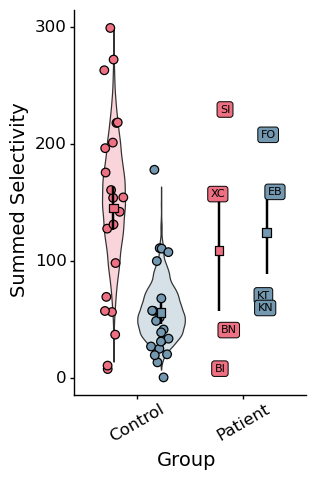


sum_selec_norm face ventral_visual_cortex


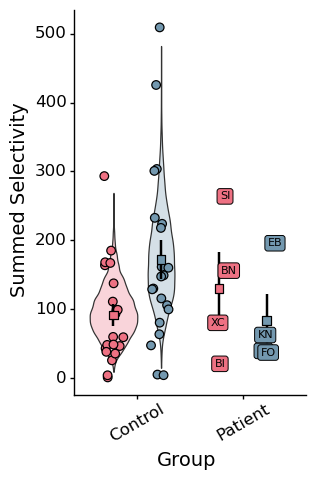


sum_selec_norm tool dorsal_visual_cortex


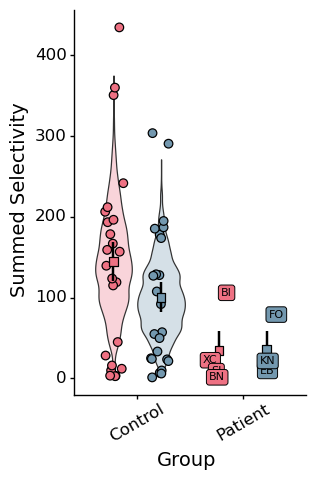


sum_selec_norm space dorsal_visual_cortex


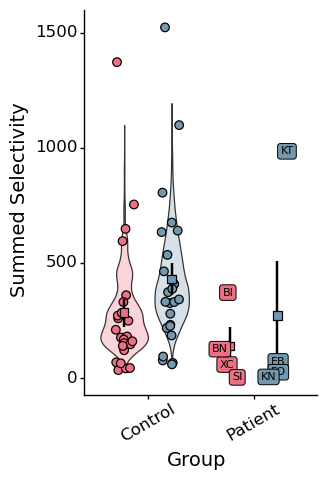


sum_selec_norm word hemi


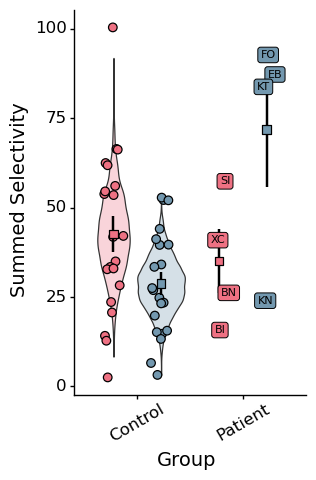


sum_selec_norm face hemi


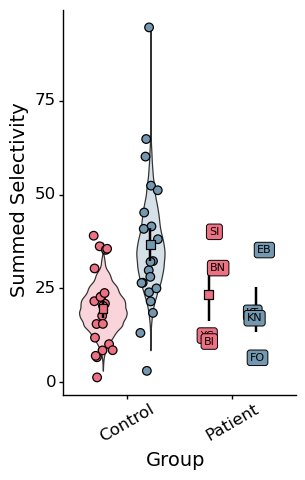


sum_selec_norm tool hemi


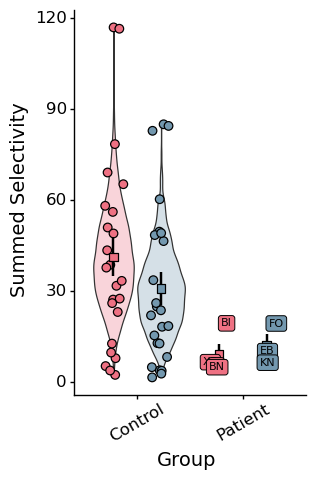


sum_selec_norm space hemi


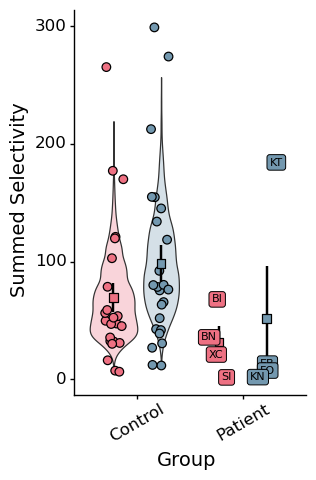


mean_act word ventral_visual_cortex


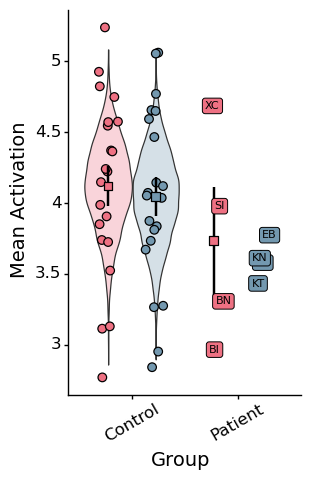


mean_act face ventral_visual_cortex


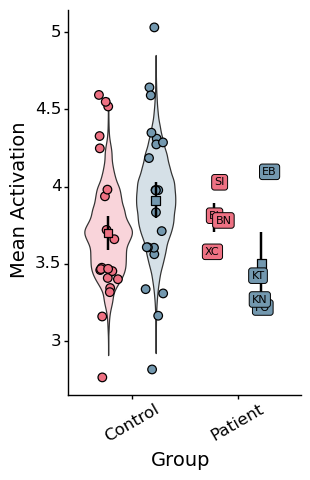


mean_act tool dorsal_visual_cortex


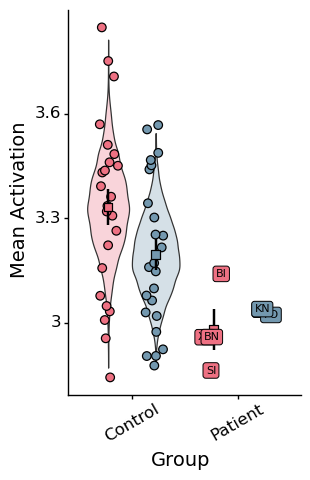


mean_act space dorsal_visual_cortex


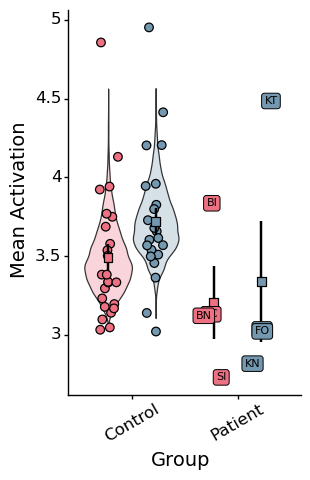


mean_act word hemi


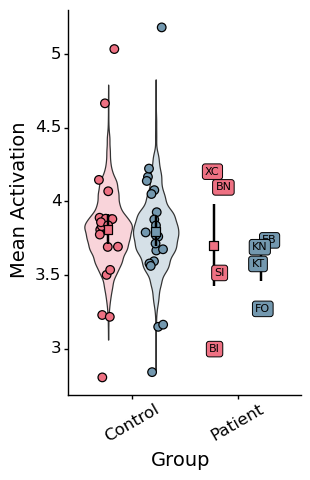


mean_act face hemi


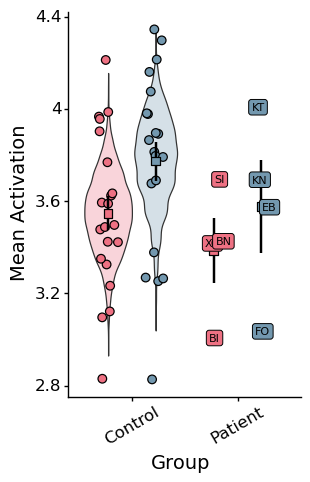


mean_act tool hemi


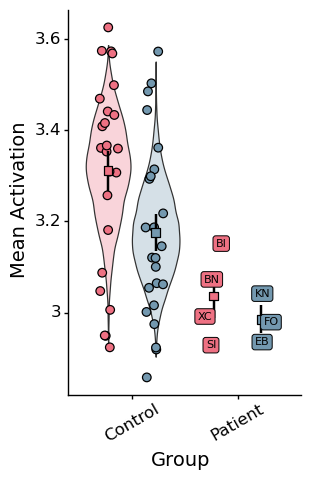


mean_act space hemi


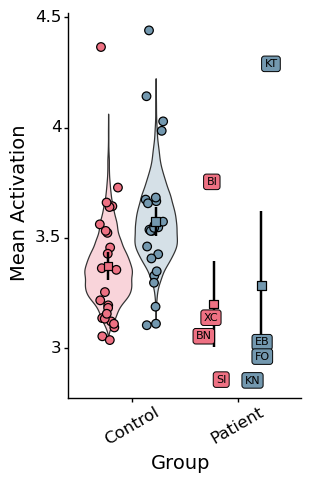


volume word ventral_visual_cortex


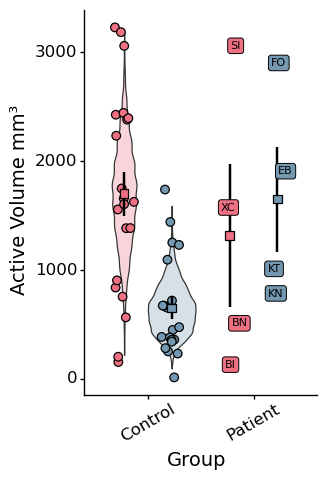


volume face ventral_visual_cortex


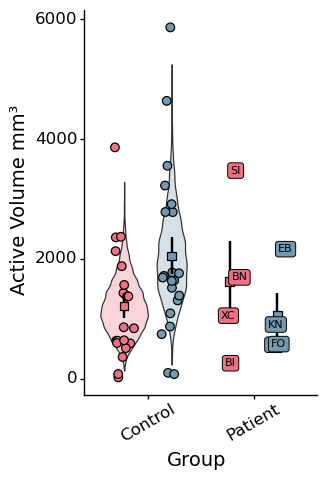


volume tool dorsal_visual_cortex


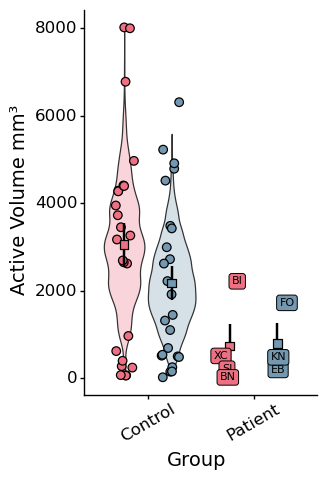


volume space dorsal_visual_cortex


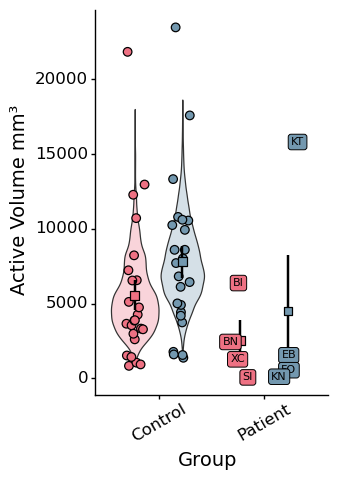


volume word hemi


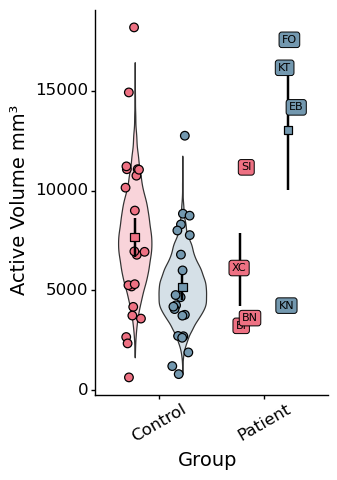


volume face hemi


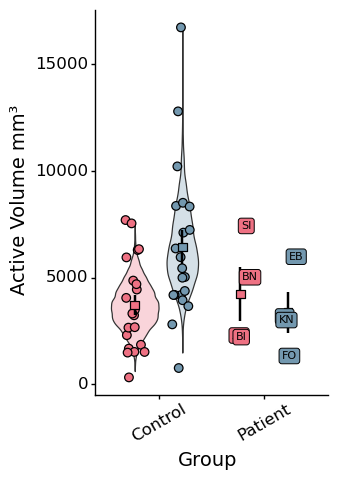


volume tool hemi


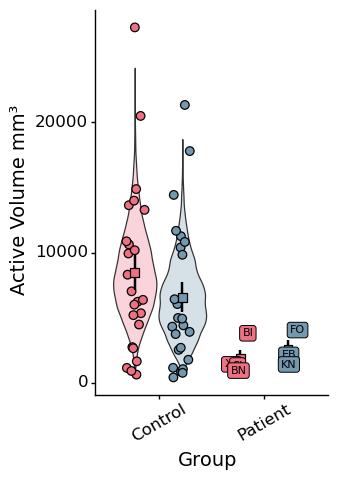


volume space hemi


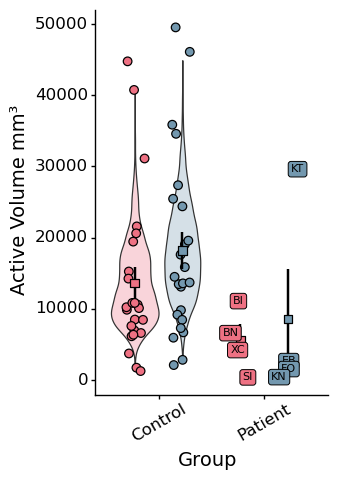

In [6]:
'''
Create selectivity plots
'''

analysis_type = 'selectivity'

#load data summary
data_summary = pd.read_csv(f'{results_dir}/{analysis_type}/{analysis_type}_summary{suf}.csv')
#capitalize hemi
data_summary['hemi'] = data_summary['hemi'].str.capitalize()

# for each sub in data_summary, get the sub's code from sub_info
for sub in data_summary['sub'].unique():
    sub_code = sub_info[sub_info['sub'] == sub]['code'].values[0]
    data_summary.loc[data_summary['sub'] == sub, 'sub_code'] = sub_code



analyses = ['sum_selec_norm', 'mean_act','volume']
analysis_names = ['Summed Selectivity', 'Mean Activation', 'Active Volume mm\u00b3']
#analyses = ['sum_selec_norm']

conds = ['word', 'face','tool','space','word', 'face','tool','space','word', 'face','tool','space']
conds = ['word', 'face','tool','space','word', 'face','tool','space']

#rois = ['dorsal_visual_cortex','dorsal_visual_cortex','ventral_visual_cortex','ventral_visual_cortex']
rois = ['ventral_visual_cortex','ventral_visual_cortex','dorsal_visual_cortex','dorsal_visual_cortex',
        'hemi','hemi','hemi','hemi', 'hemi','hemi' ]


for analysis, analysis_name in zip(analyses,analysis_names):

        
    act_resamples = pd.read_csv(f'{results_dir}/{analysis_type}/resamples/{analysis}_resamples{suf}.csv')

    #replace columns with dorsal visual cortex with dvc
    for col in act_resamples.columns:
        if 'dorsal_visual_cortex' in col:
            new_col = col.replace('dorsal_visual_cortex','dvc')
            act_resamples.rename(columns={col:new_col}, inplace=True)
        if 'ventral_visual_cortex' in col:
            new_col = col.replace('ventral_visual_cortex','vvc')
            act_resamples.rename(columns={col:new_col}, inplace=True)



    #convert act resamples to long format
    act_resamples_long = pd.melt(act_resamples, var_name='type', value_name=analysis)

    #split type column in cond, hemi, roi
    act_resamples_long[['cond','hemi','roi']] = act_resamples_long['type'].str.split('_',expand=True)

    #rename roi column
    act_resamples_long['roi'].replace('dvc','dorsal_visual_cortex',inplace=True)
    act_resamples_long['roi'].replace('vvc','ventral_visual_cortex',inplace=True)

    #capitalize hemi
    act_resamples_long['hemi'] = act_resamples_long['hemi'].str.capitalize()
    act_resamples_long['group'] = 'Control'
    
    for cond, roi in zip(conds, rois):
        print(analysis, cond, roi)

        resample_data = act_resamples_long[(act_resamples_long['cond']==cond) & (act_resamples_long['roi']==roi)]
        curr_summary = data_summary[(data_summary['cond']==cond) & (data_summary['roi']==roi)]
        curr_summary['group'] = curr_summary['group'].str.capitalize()

        #create mean and SE data for patients
        data_mean = curr_summary.groupby(['hemi', 'group']).mean().reset_index()
        data_mean_se = curr_summary.groupby(['hemi', 'group']).sem().reset_index()
        data_mean['se'] = data_mean_se[analysis]
        data_mean['group'] = data_mean['group'].str.capitalize()

        create_violin(resample_data,data_mean, curr_summary,  analysis, analysis_name, roi, cond)
    

word ventral_visual_cortex


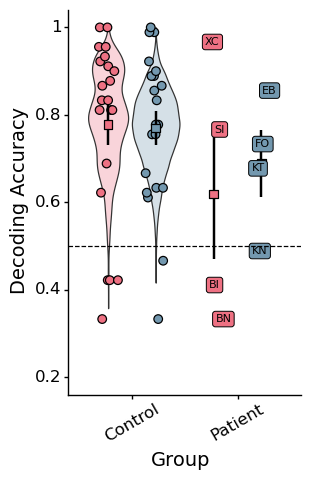


face ventral_visual_cortex


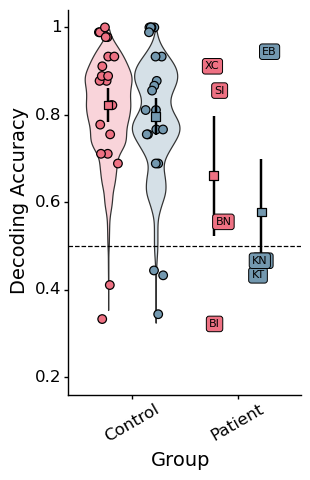


tool dorsal_visual_cortex


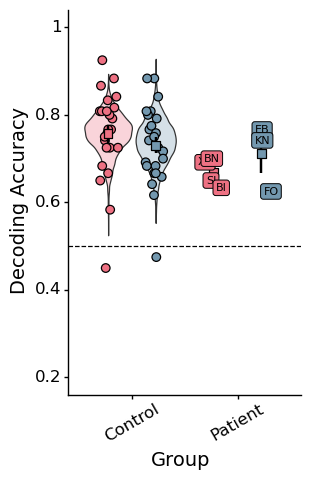


space dorsal_visual_cortex


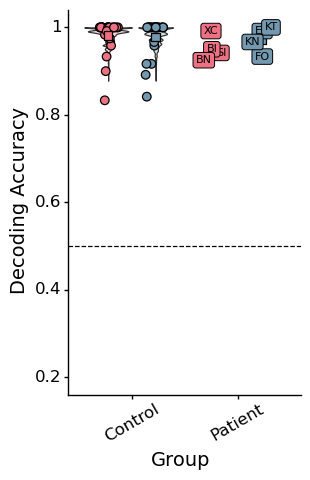

In [4]:
'''
Create decoding plots
'''

analysis_type = 'decoding'

#load data summary
data_summary = pd.read_csv(f'{results_dir}/{analysis_type}/{analysis_type}_summary{suf}.csv')
#capitalize hemi
data_summary['hemi'] = data_summary['hemi'].str.capitalize()

# for each sub in data_summary, get the sub's code from sub_info
for sub in data_summary['sub'].unique():
    try:
        sub_code = sub_info[sub_info['sub'] == sub]['code'].values[0]
        data_summary.loc[data_summary['sub'] == sub, 'sub_code'] = sub_code
    except:
        continue



analyses = ['acc']
analysis_names = ['Decoding Accuracy']

conds = ['word', 'face','tool','space']

#rois = ['dorsal_visual_cortex','dorsal_visual_cortex','ventral_visual_cortex','ventral_visual_cortex']
rois = ['ventral_visual_cortex','ventral_visual_cortex','dorsal_visual_cortex','dorsal_visual_cortex']
#rois = ['hemi', 'hemi', 'hemi','hemi']

for analysis, analysis_name in zip(analyses,analysis_names):

        
    act_resamples = pd.read_csv(f'{results_dir}/{analysis_type}/resamples/{analysis}_resamples{suf}.csv')

    #replace columns with dorsal visual cortex with dvc
    for col in act_resamples.columns:
        if 'dorsal_visual_cortex' in col:
            new_col = col.replace('dorsal_visual_cortex','dvc')
            act_resamples.rename(columns={col:new_col}, inplace=True)
        if 'ventral_visual_cortex' in col:
            new_col = col.replace('ventral_visual_cortex','vvc')
            act_resamples.rename(columns={col:new_col}, inplace=True)



    #convert act resamples to long format
    act_resamples_long = pd.melt(act_resamples, var_name='type', value_name=analysis)

    #split type column in cond, hemi, roi
    act_resamples_long[['cond','hemi','roi']] = act_resamples_long['type'].str.split('_',expand=True)

    #rename roi column
    act_resamples_long['roi'].replace('dvc','dorsal_visual_cortex',inplace=True)
    act_resamples_long['roi'].replace('vvc','ventral_visual_cortex',inplace=True)

    #capitalize hemi
    act_resamples_long['hemi'] = act_resamples_long['hemi'].str.capitalize()
    act_resamples_long['group'] = 'Control'
    
    for cond, roi in zip(conds, rois):
        print(cond, roi)
        resample_data = act_resamples_long[(act_resamples_long['cond']==cond) & (act_resamples_long['roi']==roi)]
        curr_summary = data_summary[(data_summary['cond']==cond) & (data_summary['roi']==roi)]
        curr_summary['group'] = curr_summary['group'].str.capitalize()

        #create mean and SE data for patients
        data_mean = curr_summary.groupby(['hemi', 'group']).mean().reset_index()
        data_mean_se = curr_summary.groupby(['hemi', 'group']).sem().reset_index()
        data_mean['se'] = data_mean_se[analysis]
        data_mean['group'] = data_mean['group'].str.capitalize()

        seed = 2
        p = ggplot(resample_data, aes(x = 'group', y = analysis, fill = 'hemi'))  + \
                    geom_violin( alpha = .3, position =  position_dodge(.9) ) + \
                    geom_jitter(curr_summary,aes(x = 'group', y = analysis, fill = 'hemi'), shape = 'o', size = 3, position = position_jitterdodge(dodge_width=.9, jitter_width = 0.2, random_state = seed)) + \
                    geom_linerange(data_mean, aes(x = 'group', ymin = f'{analysis} - se', ymax = f'{analysis} + se', fill = 'hemi'), size = 1,position = position_dodge(.9)) + \
                    geom_point(data_mean, aes(x = 'group', y = analysis, fill = 'hemi'), shape = 's', size = 3,position = position_dodge(.9)) + \
                    geom_label(curr_summary, aes(x = 'group', y = analysis, label = 'sub_code'),  position = position_jitterdodge(dodge_width=.9, jitter_width = 0.2, random_state = seed),  size = 8) + \
                    scale_fill_manual(values = ['#ee7183', '#7398af']) + \
                    xlab('Group') + ylab(analysis_name) + \
                    ylim(.2,1) + theme_classic() + \
                    theme(text = element_text(color ='black'), 
                        axis_text_x= element_text(angle = 30, size = 12),
                        axis_text_y= element_text(size = 12),
                        axis_title=element_text(size = 14),
                        axis_line=element_line(), 
                        legend_position = 'none',
                        panel_border=element_blank(),
                        figure_size = (3, 5))+ \
                        labs(fill='Hemisphere') + geom_hline(yintercept = 0.5, linetype = 'dashed', color = 'black')
        

        print(p)
        p.save(f'{fig_dir}/{analysis}/{roi}_{cond}.png', width=3, height=5, dpi = 300)
        
        